# Example 11: Delayed Viability Analysis

This notebook aims to understand how effectively immune cells can kill cancer cells over time. We focus on measuring the “viability” of cancer cells, which indicates how alive or healthy they are, after being in contact with immune cells. The key idea is that cell death, particularly through a process called apoptosis (a programmed form of cell death), does not happen immediately but takes a bit of time—usually around 5 to 10 minutes. As immune cells can detach and search for next target after one killing process, we need to examine the ensemble killing power after a specific period of time, named **delayed viability** here.

## Key Concepts
1. **Immune Cells and Cancer Cells**:
    - **Immune Cells**: These are the body's defenders that seek out and destroy harmful cells, including cancer cells.
    - **Cancer Cells**: These are the unhealthy cells that we are trying to kill through immune responses.

2. **Viability**:
    Viability is a measure that ranges from 0 to 1, where 1 means the cell is completely alive and healthy, and 0 means the cell is dead.
3. **Viability Gradient**:
    Viability gradient measures the rate of change in viability, a factor to indicate how fast a cell is dying.
3. **Contact and Delay**:
    When an immune cell comes into contact with a cancer cell, the immune cell can exert its killing effect, but this effect takes time. Therefore, we monitor the cancer cells' viability gradient over a delay period (denoted as $\tau$) after contact to assess how effective the immune cells are.

To incorporate time tagging and the concept of autocorrelation into the model, we need to adjust our formulations to account for the time dynamics of the immune cell's interactions with cancer cells over a specific delayed period $\tau$.

## Definitions
1. **Set of Immune Cells**:
    Let $I=\left\{I_{i,t}|i\in\mathbb{N},t\in\mathbb{T}\right\}$ be the set of immune cells, and denote an immune cell at time $I_{i,t}$ with $i$ represents the immune cell ID and $t$ as the time tag.

2. **Set of Cancer Cells in Contact**:
    - For immune cell $I_{i,t}$ , let the set of cancer cells $C_{i,t}$ it contacts at time $t$ be denoted as $C=\{C_{i,t}|I_{i,t}\in I\}$.
    - Each cancer cell $c_{j,k}$ at time $k$ in this set will have its viability at time $V=\{V_{C_{j,k}}|c_j\in C_{i,k}, k\in \mathbb{T}\}$ with real number range $[0,1]$ where 0 represents cell death and 1 represents full viability.

3. **Delayed Time Period**:
  The delayed time period is denoted by $\tau$, which indicates the monitoring duration after the initial contact (from $t$ to $t+\tau$).

## Delayed Viability Gradient
The delayed viability gradient $G_{i,t}$ for immune cell $I_{i,t}$ over a delayed time period $t$ to $t+\tau$ can be expressed as the average rate of change in the viability of the cancer cells in contact during this period:

$$G_{i,t} = \frac{1}{N_{i,t,\tau}} \sum_{k=t}^{t+\tau} \sum_{j\in C_{i,k}}\left(\frac{V_{C_{j,k}}-V_{C_{j,k-1}}}{\Delta t}\right)$$
 
Where:
- $N_{i,t,\tau}$ is the total number of cancer cells in contact with immune cell $I_{i,t}$ from time $t$ to $t+\tau$, given by:
$$N_{i,t,\tau}=\sum_{k=t}^{t+\tau}\left|C_{i,k}\right|$$
- $\left|C_{i,k}\right|$ is the number of cancer cells in contact with immune cell $I_{i,t}$ at time $k$
- The inner sum $\sum_{j\in C_{i,k}}\left( \frac{V_{C_{j,k}} - V_{C_{j,k-1}}}{\Delta t} \right)$ represents the rate of change in viability per unit time for cancer cells in contact at each time step.

### Contact Weight
To model the interaction where one cancer cell can be in contact with multiple immune cells during the delay period, we may introduce a weighting factor that accounts for the influence of the specific immune cell we are examining. This weight will reflect how much of the killing effect on a cancer cell can be attributed to the immune cell $I_{i,t}$, relative to other immune cells it interacts with over the delayed period $\tau$.

We introduce a contact contribution weight $w_{i,j,k}$ for each cancer cell $C_{j,k}$ in contact with immune cell $I_{i,t}$ at time $k$. The weight $w_{i,j,k}$ represents the proportion of the interaction between immune cell $I_{i,t}$ and cancer cell $C_{j,k}$ compared to the total number of immune cells in contact with $C_{j,k}$ at time $k$.

The updated equation for the weighted viability gradient then is:
$$G_{i,t} = \frac{1}{N_{i,t,\tau}} \sum_{k=t}^{t+\tau} \sum_{j\in C_{i,k}} w_{i,j,k}\left(\frac{V_{C_{j,k}}-V_{C_{j,k-1}}}{\Delta t}\right)$$

The **weighting factor** $w_{i,j,k}=1/\left|I_{j,k}\right|$ is the  number of immune cells in contact with cancer cell $C_{j,k}$ at time $k$. This ensures that the effect is proportionally distributed across all immune cells interacting with the cancer cell. If $I_{i,t}$ is the only immune cell in contact with cancer cell $C_{j,k}$, $w_{i,j,k} = 1$. If multiple immune cells are in contact, the weight decreases, reflecting the shared contribution.

In [1]:
import pandas as pd
import numpy as np
from cyto.postprocessing.sparse_to_sparse import *
import matplotlib.pyplot as plt
import seaborn as sns
from dask.distributed import Client
import dask.dataframe as dd
import networkx as nx

## Notebook Setup

In [2]:
client = Client()
client

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/distributed/node.py:182: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 46261 instead
  warnings.warn(


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:46261/status,
Dashboard: http://127.0.0.1:46261/status,Workers: 8
Total threads: 32,Total memory: 251.55 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:36401,Workers: 8
Dashboard: http://127.0.0.1:46261/status,Total threads: 32
Started: Just now,Total memory: 251.55 GiB
Comm: tcp://127.0.0.1:36679,Total threads: 4
Dashboard: http://127.0.0.1:41437/status,Memory: 31.44 GiB
Nanny: tcp://127.0.0.1:45197,


# Data Loading

In [3]:
TCELL_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Tcell/track_tcell_merge_int_contact_ddf.csv"

CANCER_DATA_PATH = "/mnt/Data/UTSE/2023_11_24_1G4PrimCD8_Nyeso1_HCT116_CTFR_100nM_ICAM5ug_framerate10sec_flow_0p1mlperh_analysis/plots/contact_analysis/Cyto/Cancer/track_cancer_merge_int_contact_ddf.csv"

In [4]:
tcell_ddf = dd.read_csv(TCELL_DATA_PATH)
cancer_ddf = dd.read_csv(CANCER_DATA_PATH)

In [5]:
tcell_ddf.head()

,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,...,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels
0,23506300,858.538462,236.400000,233,854,8,11,236.400000,858.538462,233.0,...,0.670776,993,1023,70.276939,176.907692,170.613281,46.081356,1.278615,True,[125845 126247 128438]
1,23538897,431.114583,745.031250,740,425,10,13,745.031250,431.114583,740.0,...,0.118768,179,180,96.497207,197.677083,181.884766,87.373909,2.257658,True,[154477 155484 156668]
2,23567508,793.029557,991.211823,982,785,18,16,991.211823,793.029557,982.0,...,2.972191,356,441,91.668539,283.083744,236.503906,132.560346,4.948832,True,[178131 178237]
3,23622464,609.587629,245.000000,240,605,11,11,245.000000,609.587629,240.0,...,0.412371,3636,3637,90.530528,133.309278,110.714844,9.515733,0.417839,True,[224965]
4,23639053,702.212389,738.796460,733,696,11,14,738.796460,702.212389,733.0,...,0.294173,304,320,96.565789,151.637168,124.521484,16.637985,2.199979,True,[237891]


## Calculate Viability for the Cells

Normalized cell viability is defined in [./example_9.ipynb](./example_9.ipynb).

In [7]:
tcell_ddf,_,_ = intensity_norm_percentile(tcell_ddf,channel="ctfr_mean", percentile=1)
tcell_ddf,_,_ = intensity_norm_percentile(tcell_ddf,channel="pi_mean", percentile=1)

cancer_ddf,_,_ = intensity_norm_percentile(cancer_ddf,channel="gfp_mean", percentile=1)
cancer_ddf,_,_ = intensity_norm_percentile(cancer_ddf,channel="pi_mean", percentile=1)

In [8]:
tcell_ddf = cal_viability(tcell_ddf,pos_cols=["ctfr_mean_norm"], neg_cols=["pi_mean_norm"])
tcell_ddf

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,ctfr_mean,ctfr_median,ctfr_sd,closest cell dist,contact,contacting cell labels,ctfr_mean_norm,pi_mean_norm,viability
npartitions=158,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [9]:
cancer_ddf = cal_viability(cancer_ddf,pos_cols=["gfp_mean_norm"], neg_cols=["pi_mean_norm"])
cancer_ddf

/home/jackyko/mambaforge/envs/cyto/lib/python3.10/site-packages/dask/dataframe/core.py:5983: UserWarning: 
You did not provide metadata, so Dask is running your function on a small dataset to guess output types. It is possible that Dask will guess incorrectly.
To provide an explicit output types or to silence this message, please provide the `meta=` keyword, as described in the map or apply function that you are using.
  Before: .apply(func)
  After:  .apply(func, meta=(None, 'float64'))

  warnings.warn(meta_warning(meta))


,label,y,x,bbox_xstart,bbox_ystart,bbox_xsize,bbox_ysize,i,j,bbox_istart,bbox_jstart,bbox_isize,bbox_jsize,size,elongation,flatness,roundness,feret_diameter,feret_radius,perimeter,mass,pi_mean,pi_median,pi_sd,frame,channel,alive,track_id,id,dist_from_ultrack,tracked frames,tracked length,mean tracked cell size,gfp_mean,gfp_median,gfp_sd,closest cell dist,contact,contacting cell labels,gfp_mean_norm,pi_mean_norm,viability
npartitions=180,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,int64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,object,float64,int64,int64,float64,int64,int64,float64,float64,float64,float64,float64,bool,object,float64,float64,float64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


## Plot the Cell Contact at Specific Frame as Graph

In [10]:
FRAME = 10

tcell_frame = tcell_ddf[tcell_ddf["frame"]==FRAME].compute()
cancer_frame = cancer_ddf[cancer_ddf["frame"]==FRAME].compute()

In [12]:
# create networkx graph for contact visualization
G = nx.Graph()

for idx, row in tcell_frame.iterrows():
    G.add_node("t_{}".format(row["label"]-(tcell_frame['frame'] < row["frame"]).sum()), pos=(row['i'], row['j']), node_type='T Cell')

for idx, row in cancer_frame.iterrows():
    G.add_node("c_{}".format(row["label"]-(tcell_frame['frame'] < row["frame"]).sum()), pos=(row['i'], row['j']), node_type='Cancer Cell')

# add contact as edges
for i, (_, tcell_row) in enumerate(tcell_frame.iterrows()):
    contacting_cancer_labels = tcell_row["contacting cell labels"]
    # Remove the square brackets
    contacting_cancer_labels = contacting_cancer_labels.strip('[]')

    for j in contacting_cancer_labels.split():
        if "c_{}".format(j) in G.nodes:
            G.add_edge("t_{}".format(tcell_row["label"]),"c_{}".format(j))


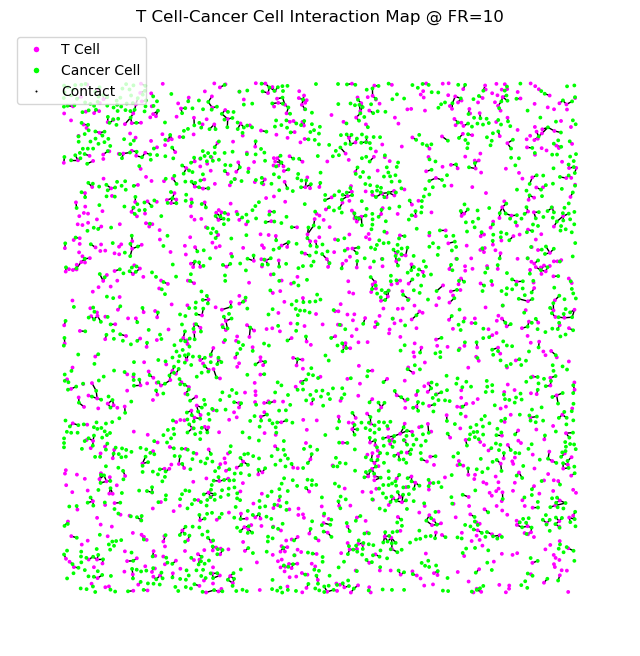

In [13]:
fig, axs = plt.subplots(1,1,figsize=(8,8))

# Get the node positions for plotting
pos = nx.get_node_attributes(G, 'pos')

# Get node colors based on type
node_colors = []
for node in G.nodes(data=True):
    try:
        if node[1]['node_type'] == 'T Cell':
            node_colors.append('magenta')
        else:
            node_colors.append('lime')
    except:
        pass

# Draw the nodes and edges
nx.draw(G, pos, with_labels=False, node_color=node_colors, node_size=3, font_size=10, font_color='black',ax=axs)

# Create a custom legend
legend_handles = [
    plt.Line2D([0], [0], marker='o', color='w', label='T Cell', markersize=5, markerfacecolor='magenta'),
    plt.Line2D([0], [0], marker='o', color='w', label='Cancer Cell', markersize=5, markerfacecolor='lime'),
    plt.Line2D([0], [0], marker='.', color='w', label='Contact', markersize=5, markerfacecolor='black')
]

axs.set_axis_off()
axs.set_title("T Cell-Cancer Cell Interaction Map @ FR={}".format(FRAME))
# axs.legend()
axs.legend(handles=legend_handles, loc='upper left')

## Compute Delayed Viability

For exploration purpose, here we provide a simulated data generator to show data structures:

In [14]:
import random

# Function to generate random contact data with integer cell IDs
def generate_immune_cells(num_cells=100):
    immune_cells = []
    for i in range(num_cells):
        cell_id = i + 1  # Use integers for immune cell IDs
        frame = i % 10  # Simulate 10 frames (0 to 9)
        # Randomly generate contacts, some cells may have no contacts
        if random.choice([True, False]):  # Randomly decide if there are contacts
            contacts = random.sample(range(1, 51), random.randint(1, 5))  # Use integers for cancer cell IDs (1 to 50)
        else:
            contacts = []
        immune_cells.append({
            'cell_id': cell_id,
            'frame': frame,
            'viability': None,  # Placeholder for viability
            'list_of_cell_ids_in_contact': contacts
        })
    return pd.DataFrame(immune_cells)

# Generate the DataFrame for immune cells
immune_cells_df = generate_immune_cells()

# Generate a DataFrame for cancer cells with integer IDs and corresponding viabilities
cancer_cells_data = {
    'cell_id': list(range(1, 51)),  # Integer IDs for cancer cells (1 to 50)
    'viability': [round(random.uniform(0.4, 1.0), 2) for _ in range(50)],
}

cancer_cells_df = pd.DataFrame(cancer_cells_data)

print(immune_cells_df.head())
print(cancer_cells_df.head())

   cell_id  frame viability list_of_cell_ids_in_contact
0        1      0      None                          []
1        2      1      None                          []
2        3      2      None                [22, 41, 18]
3        4      3      None               [2, 50, 9, 4]
4        5      4      None                          []
   cell_id  viability
0        1       0.54
1        2       0.49
2        3       0.94
3        4       0.53
4        5       0.55


### Delayed Viability Compute

In [15]:
tcell_ddf.columns

Index(['label', 'y', 'x', 'bbox_xstart', 'bbox_ystart', 'bbox_xsize',
       'bbox_ysize', 'i', 'j', 'bbox_istart', 'bbox_jstart', 'bbox_isize',
       'bbox_jsize', 'size', 'elongation', 'flatness', 'roundness',
       'feret_diameter', 'feret_radius', 'perimeter', 'mass', 'pi_mean',
       'pi_median', 'pi_sd', 'frame', 'channel', 'alive', 'track_id', 'id',
       'dist_from_ultrack', 'tracked frames', 'tracked length',
       'mean tracked cell size', 'ctfr_mean', 'ctfr_median', 'ctfr_sd',
       'closest cell dist', 'contact', 'contacting cell labels',
       'ctfr_mean_norm', 'pi_mean_norm', 'viability'],
      dtype='object')

In [16]:
from tqdm import tqdm

def compute_delayed_viability(immune_cells_df, cancer_cells_df, tau=1):
    """
    Computes the delayed viability of cancer cells in contact with immune cells over time.
    
    Parameters:
    - immune_cells_df: DataFrame containing immune cell data with columns 'label', 'frame', 'contacting cell labels'
    - cancer_cells_df: DataFrame containing cancer cell data with columns 'label', 'viability'
    - tau: int, the delay period (default: 30 frames)
    
    Returns:
    - Immune cell dataFrame appending the mean/median delayed viability column
    """
    
    # Iterate over each immune cell
    for i, (index, immune_cell) in tqdm(enumerate(immune_cells_df.iterrows())):
        if i > 10: 
            break

        immune_cell_id = immune_cell['label']
        current_frame = immune_cell['frame']
        cell_ids_in_contact = immune_cell["contacting cell labels"]
        delayed_frame = current_frame+tau

        # trace the viability of the contacted cancer cell within the delayed period
        for cancer_cell_id in cell_ids_in_contact:
            # Check the trackid of the cancer cell in contact
            track_id = cancer_cells_df[cancer_cells_df['label'] == cancer_cell_id]["track_id"]

            # filter out the cancer cell with same track id and within the delayed time period
            cancer_cell_delayed = cancer_cells_df[
                cancer_cells_df["track_id"]==track_id & 
                cancer_cells_df["frame"]>=current_frame &
                cancer_cells_df["frame"]<=delayed_frame
                ]
            
            

        #     if not viability.empty:
        #         viability_value = viability.iloc[0]  # Get the viability value
        #         results.append({
        #             'immune_cell_id': immune_cell_id,
        #             'cancer_cell_id': cancer_cell_id,
        #             'delayed_frame': delayed_frame,
        #             'viability': viability_value
        #         })

    #     # If there are no contacts, still add the entry with NaN for viability
    #     if not cell_ids_in_contact:
    #         results.append({
    #             'immune_cell_id': immune_cell_id,
    #             'cancer_cell_id': None,
    #             'delayed_frame': delayed_frame,
    #             'viability': np.nan
    #         })

    # # Convert results to DataFrame
    # results_df = pd.DataFrame(results)

    # # Calculate average and median delayed viability for each immune cell
    # final_results = results_df.groupby('immune_cell_id').agg(
    #     average_delayed_viability=('viability', 'mean'),
    #     median_delayed_viability=('viability', 'median')
    # ).reset_index()

    final_results = immune_cells_df

    return final_results

# Call the function to calculate delayed viability
delayed_viability_results = compute_delayed_viability(tcell_ddf, cancer_ddf, tau=30)

# Output the results
print(delayed_viability_results)

0it [00:12, ?it/s]


ValueError: The truth value of a Series is ambiguous. Use a.any() or a.all().